# RELIEF-based feature selection methods

In the present notebook, we will applied RELIEF-based selection methods (RBAs) for biomarker discovery (followed by gene enrichment analysis), and for dimensionality reduction to further implement ML models to differentiate between tumor and healthy breast tissue, based on microarray data available at the NIH - Gene Expression Omnibus (Superseries [GSE70951](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70951)).

## Data extraction and correction

The GSE70951 is composed of two series:

* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_1]*, with the code [GSE70905](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70905), which will be used as an external validation dataset
* *Age and estrogen-dependent inflammation in breast adenocarcinoma and normal breast tissue [cohort_2]*, with the code [GSE70947](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70947), which will be used for biomarker discovery

We will be using the second cohort in our study.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The data preprocessing and differential gene expression analysis was done in R using the `limma` package.

In [ ]:
!gdown https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
!gdown https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2

Downloading...
From: https://drive.google.com/uc?id=1tITWOKQoUZjQf1VgIaaKhxtHzImFH7fo
To: /content/GSE70947.csv
100% 176M/176M [00:02<00:00, 61.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ViDbGJZU6RfwDPAfhnF7gjcFeQtyg_u2
To: /content/GSE70947_DGE_filtered.csv
100% 296k/296k [00:00<00:00, 29.4MB/s]


The GSE70947` file has the gene expression information. The columns are divided in
* `index`, which have the GEO code for each patient
* `type`, which has the class at which each patient belongs (either healthy or adenocarcinoma)
* the rest of the columns, that have the name of the gen an its expression level

In [ ]:
gse = pd.read_csv('GSE70947.csv', index_col = 0)
gse.head()

,NM_144987,NM_013290,ENST00000322831,NM_001625,lincRNA:chr7:226042-232442_R,NM_032391,ENST00000238571,XR_108906,NM_005937,NM_152493,...,NM_152343,NM_001005327,NM_001039355,lincRNA:chr21:44456656-44468556_R,lincRNA:chr9:4869500-4896050_F,NM_016053,NM_001080425,ENST00000555638,ENST00000508993,type
GSM1823702,8.710837,7.752260,6.147044,11.330250,8.049364,4.786607,5.762913,4.673030,8.595702,10.700061,...,6.452793,4.861030,10.751960,5.231761,6.099910,10.653872,8.983922,5.117210,5.231761,healthy
GSM1823703,9.386920,7.125349,7.033364,11.043588,8.546755,5.365691,5.564553,4.966745,8.505314,10.952910,...,5.836469,3.858494,11.302093,4.003188,3.858494,10.751094,8.199526,4.085583,4.355808,healthy
GSM1823704,8.958187,7.993491,6.358601,11.548966,8.616110,5.402829,5.941259,5.093209,8.683907,10.574121,...,6.668138,3.793648,10.581576,5.137291,6.605187,10.435313,8.493851,4.669778,5.225001,healthy
GSM1823705,9.034777,7.856471,6.260612,12.290221,7.724913,4.631357,6.745727,4.840550,8.573251,10.787665,...,5.905563,4.458250,11.178242,5.123130,6.739206,11.113692,8.896214,4.358008,4.631357,healthy
GSM1823706,8.822363,7.593622,6.322608,12.204265,7.785088,4.295037,6.597042,4.366717,8.788972,10.818610,...,5.672441,4.557420,12.016128,5.110453,6.496323,10.913592,9.536360,4.673507,4.557420,healthy


The `DGE` file contains the results of the differential gene expression, considering a $\log |\text{FC}| > 1$ and $\text{adj.P-val} < 0.05$ as thresholds

In [ ]:
dge = pd.read_csv('GSE70947_DGE_filtered.csv', index_col = 0)
dge.head()

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,diffexpressed
lincRNA:chr2:216585154-216585719_F,lincRNA:chr2:216585154-216585719_F,3.725171,7.142946,16.750688,1.316560e-44,3.454359e-40,90.700821,UP
NM_006086,NM_006086,3.048427,7.739344,16.663225,2.786762e-44,3.454359e-40,89.958877,UP
NM_004456,NM_004456,1.699635,7.972860,16.625759,3.842303e-44,3.454359e-40,89.641072,UP
NM_002141,NM_002141,-1.344960,7.782020,-16.404438,2.561246e-43,1.726984e-39,87.764022,DOWN
lincRNA:chr4:89637527-89646627_R,lincRNA:chr4:89637527-89646627_R,-1.904182,7.375651,-16.067836,4.577865e-42,2.469392e-38,84.910909,DOWN


Extracting the target,

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = gse["type"]
y = LabelEncoder().fit_transform(y)

and storing the data in the variable `X`.

In [ ]:
X = gse.drop(["type"], axis = 1)
X = X[np.array(dge["ID"])]
X.head()

,lincRNA:chr2:216585154-216585719_F,NM_006086,NM_004456,NM_002141,lincRNA:chr4:89637527-89646627_R,NM_014736,NM_005480,NM_016359,NM_004336,NM_001083961,...,NM_001178126,NP113779,S77011,ENST00000498435,NM_002411,A_33_P3251412,NM_012188,NM_006552,NM_006551,NM_002652
GSM1823702,4.786607,6.321416,6.808873,8.685651,9.205305,5.675846,6.558804,6.124203,4.509872,7.197222,...,13.480088,9.728459,12.696556,9.518063,7.363144,9.754804,5.468174,7.310242,7.644311,8.949257
GSM1823703,7.644079,9.365653,7.938209,7.063652,7.311140,7.116449,7.892767,7.016965,4.633230,8.543367,...,13.369119,10.337995,12.618046,10.213340,12.581711,8.704484,6.232431,11.249700,11.713772,13.530426
GSM1823704,4.687383,4.830394,6.870517,8.485212,10.360521,5.066081,6.646007,4.805947,3.501254,7.634662,...,10.077759,6.817671,9.302829,6.409630,3.621975,6.006907,1.449203,4.598337,4.635677,4.456936
GSM1823705,5.097593,5.676941,7.078230,8.328697,9.077607,5.916410,6.553197,5.758328,4.256620,7.382161,...,13.854754,11.696181,12.933871,10.968928,11.478130,9.929380,8.450231,11.012945,11.134689,12.588631
GSM1823706,5.012687,5.626693,7.558369,8.562031,9.844757,6.741824,6.729353,6.239319,5.328063,7.545784,...,17.035073,14.224910,16.074557,13.696180,16.456441,13.741491,7.200912,15.944112,15.928179,17.924073


## RBA-based feature selection

The implementation is done based on Urbanowicz et al (2016) [article](https://www.sciencedirect.com/science/article/pii/S1532046418301400), and using the `scikit-rebate` package, whose documentation can be found [here](https://epistasislab.github.io/scikit-rebate/using/#acquiring-feature-importance-scores).

In [ ]:
!pip install -q skrebate

  Preparing metadata (setup.py) ... done


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

### Relief

In [ ]:
#@title Classic implementation
# """
# This implementation is based on the documentation of the scikit-rebate package
# https://epistasislab.github.io/scikit-rebate/using/
# """
# from skrebate import ReliefF
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_validate

# _scoring = ['accuracy', 'precision', 'recall', 'f1']
# vec = np.linspace(3,51,49)
# k_fold_metric = []
# importances = {}

# for nn in vec:

#   # Feature selection by Relief
#   fs = ReliefF(n_neighbors = nn,
#               n_jobs = 2)

#   fs.fit(X_train.values, y_train)

#   fs_results = pd.DataFrame({'Features': X_train.columns, 'Feature importances': fs.feature_importances_})
#   fs_results = fs_results.sort_values(by = ['Feature importances'], ascending = False)

#   # Select features with importance higher than 0
#   top_features = fs_results[fs_results['Feature importances'] > 0]
#   importances[nn] = len(fs_results['Features'])

#   # Random Forest implementation
#   rf = RandomForestClassifier(n_estimators = 100)
#   rf.fit(X_train[top_features['Features']], y_train)
#   k_fold_metric.append(cross_validate(estimator=rf,
#                               X=X_train[top_features['Features']],
#                               y=y_train,
#                               cv=5,
#                               scoring=_scoring,
#                               return_train_score=True))

# # Visualizing the results
# metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

# plt.figure(figsize=(10,4))
# for n, score in enumerate(metrics):

#   ax = plt.subplot(2,2, n+1)

#   exp = [k_fold_metric[i][score].mean() for i in range(len(vec))]
#   ax.plot(range(len(vec)), exp)
#   ax.set_title(f'{score}')
#   #ax.set_xticks(range(len(vec)), [int(i) for i in vec])

# plt.tight_layout()
# plt.show()

As we can observe, there is no linear relationship between the number of `n_neighbors` and the performance metrics of the Random Forest classifier, suggesting that we need another condition besides "higher values of `n_neighbors`" (cite). To rule out the effect of the classifier, an SVM (cite) and Logistic Regression model (cite) will be analyzed, too.

In [ ]:
all(list(importances.values()))

In [ ]:
print(importances[3.0])

As we can see, the `ReliefF()` method is still considering every feature as important. Then, we can check if there are features whose importance is repeated among different values of `n_neighbors`.

In [ ]:
from skrebate import ReliefF

vec = np.linspace(3,51,49)
importances = {'Genes': X_train.columns}

for nn in vec:

  # Feature selection by Relief
  fs = ReliefF(n_neighbors = nn,
              n_jobs = 2)

  fs.fit(X_train.values, y_train)

  importances[int(nn)] = fs.feature_importances_

In [ ]:
import scipy.stats as ss

importances = pd.DataFrame(importances)
for key in importances:
  if key == 'Genes':
    pass
  else:
    importances[key] = ss.rankdata(importances[key], method = 'ordinal')

importances.head()

We can observe that the feature importance value is dependant on the value of `n_neighbors`, suggesting that further optimization is needed. However, defining the optimal value of k (just like in the [KNN algorithm](https://stackoverflow.com/questions/11568897/value-of-k-in-k-nearest-neighbor-algorithm)) based on trial-and-error might cause bias to the dataset. Then, the SURF and Multi SURF methods (and their derivations) will be implemented, considering that they estimate the `n_neighbors`.

Just to rule out the "higher value of `n_neighbors`, higher performance" hypothesis, we will run (at the expense of computational cost) for `n_neighbors` up to 100 too see if the feature importances converge.


In [ ]:
#@title n_neighbors = 100
# from skrebate import ReliefF
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_validate

# _scoring = ['accuracy', 'precision', 'recall', 'f1']
# vec = np.linspace(3,100,98)
# k_fold_metric = []
# importances = {}

# for nn in vec:

#   # Feature selection by Relief
#   fs = ReliefF(n_neighbors = nn,
#               n_jobs = 2)

#   fs.fit(X_train.values, y_train)

#   fs_results = pd.DataFrame({'Features': X_train.columns, 'Feature importances': fs.feature_importances_})
#   fs_results = fs_results.sort_values(by = ['Feature importances'], ascending = False)

#   # Select top features
#   top_features = fs_results[fs_results['Feature importances'] > 0]
#   importances[nn] = len(fs_results['Features'])

#   # Random Forest implementation
#   rf = RandomForestClassifier(n_estimators = 100)
#   rf.fit(X_train[top_features['Features']], y_train)
#   k_fold_metric.append(cross_validate(estimator=rf,
#                               X=X_train[top_features['Features']],
#                               y=y_train,
#                               cv=5,
#                               scoring=_scoring,
#                               return_train_score=True))

# # Visualizing the results
# metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

# plt.figure(figsize=(10,4))
# for n, score in enumerate(metrics):

#   ax = plt.subplot(2,2, n+1)

#   exp = [k_fold_metric[i][score].mean() for i in range(len(vec))]
#   ax.plot(range(len(vec)), exp)
#   ax.set_title(f'{score}')
#   #ax.set_xticks(range(len(vec)), [int(i) for i in vec])

# plt.tight_layout()
# plt.show()

### SURF

In [ ]:
#@title SURF implementation
from skrebate import SURF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

_scoring = ['accuracy', 'precision', 'recall', 'f1']
importances_surf = {'Genes': X_train.columns}

# Feature selection by Relief
fs = SURF(n_jobs = 2)

fs.fit(X_train.values, y_train)

fs_surf = pd.DataFrame({'Features': X_train.columns, 'Feature importances': fs.feature_importances_})
fs_surf = fs_surf.sort_values(by = ['Feature importances'], ascending = False)

# Select top features
top_features_surf = fs_surf[fs_surf['Feature importances'] > 0]
print('Number of important features: '+ str(len(top_features_surf)))

# Random Forest implementation
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train[top_features_surf['Features']], y_train)
surf = cross_validate(estimator=rf,
                            X=X_train[top_features_surf['Features']],
                            y=y_train,
                            cv=5,
                            scoring=_scoring,
                            return_train_score=True)

# Visualizing the results
# print('Accuracy: ' + str(surf['test_accuracy'].mean()))
# print('Precision: ' + str(surf['test_precision'].mean()))
# print('Recall: ' + str(surf['test_recall'].mean()))
# print('F1: ' + str( surf['test_f1'].mean()))

Number of important features: 1545


### SURF*

In [ ]:
#@title SURF* implementation
from skrebate import SURFstar
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

_scoring = ['accuracy', 'precision', 'recall', 'f1']
importances_surf2 = {'Genes': X_train.columns}

# Feature selection by Relief
fs = SURFstar(n_jobs = 2)

fs.fit(X_train.values, y_train)

fs_surf2 = pd.DataFrame({'Features': X_train.columns, 'Feature importances': fs.feature_importances_})
fs_surf2 = fs_surf2.sort_values(by = ['Feature importances'], ascending = False)

# Select top features
top_features_surf2 = fs_surf2[fs_surf2['Feature importances'] > 0]
print('Number of important features: '+ str(len(top_features_surf2)))

# Random Forest implementation
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train[top_features_surf2['Features']], y_train)
surf2 = cross_validate(estimator=rf,
                            X=X_train[top_features_surf2['Features']],
                            y=y_train,
                            cv=5,
                            scoring=_scoring,
                            return_train_score=True)

# Visualizing the results
# print('Accuracy:'+ str(surf2['test_accuracy'].mean()))
# print('Precision:' + str(surf2['test_precision'].mean()))
# print('Recall:' + str(surf2['test_recall'].mean()))
# print('F1:' + str(surf2['test_f1'].mean()))

Number of important features: 209


### Multi-SURF

In [ ]:
#@title MultiSURF implementation
from skrebate import MultiSURF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

_scoring = ['accuracy', 'precision', 'recall', 'f1']
importances_multi_surf = {'Genes': X_train.columns}

# Feature selection by Relief
fs = MultiSURF(n_jobs = 2)

fs.fit(X_train.values, y_train)

fs_multi_surf = pd.DataFrame({'Features': X_train.columns, 'Feature importances': fs.feature_importances_})
fs_multi_surf = fs_multi_surf.sort_values(by = ['Feature importances'], ascending = False)

# Select top features
top_features_multisurf = fs_multi_surf[fs_multi_surf['Feature importances'] > 0]
print('Number of important features: '+ str(len(top_features_multisurf)))

# Random Forest implementation
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train[top_features_multisurf['Features']], y_train)
multi_surf = cross_validate(estimator=rf,
                            X=X_train[top_features_multisurf['Features']],
                            y=y_train,
                            cv=5,
                            scoring=_scoring,
                            return_train_score=True)

# Visualizing the results
# print('Accuracy: ' + str(multi_surf['test_accuracy'].mean()))
# print('Precision: ' + str(multi_surf['test_precision'].mean()))
# print('Recall: '  + str(multi_surf['test_recall'].mean()))
# print('F1:' + str(multi_surf['test_f1'].mean()))

Number of important features: 1423


###Multi-SURF*

In [ ]:
#@title MultiSURF* implementation
from skrebate import MultiSURFstar
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

_scoring = ['accuracy', 'precision', 'recall', 'f1']
importances_multi_surf2 = {'Genes': X_train.columns}

# Feature selection by Relief
fs = MultiSURFstar(n_jobs = 2)

fs.fit(X_train.values, y_train)

fs_multi_surf2 = pd.DataFrame({'Features': X_train.columns, 'Feature importances': fs.feature_importances_})
fs_multi_surf2 = fs_multi_surf2.sort_values(by = ['Feature importances'], ascending = False)

# Select top features
top_features_multisurf2 = fs_multi_surf2[fs_multi_surf2['Feature importances'] > 0]
print('Number of important features: '+ str(len(top_features_multisurf2)))

# Random Forest implementation
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train[top_features_multisurf2['Features']], y_train)
multi_surf2 = cross_validate(estimator=rf,
                            X=X_train[top_features_multisurf2['Features']],
                            y=y_train,
                            cv=5,
                            scoring=_scoring,
                            return_train_score=True)

# Visualizing the results
# print('Accuracy: ' + str(multi_surf2['test_accuracy'].mean()))
# print('Precision: ' + str(multi_surf2['test_precision'].mean()))
# print('Recall: ' + str(multi_surf2['test_recall'].mean()))
# print('F1: ' + str(multi_surf2['test_f1'].mean()))

Number of important features: 414


### TURF

In [ ]:
#@title TURF implementation
from skrebate import TuRF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

_scoring = ['accuracy', 'precision', 'recall', 'f1']
importances_turf = {'Genes': X_train.columns}

# Feature selection by Relief
fs = TuRF(core_algorithm="ReliefF", pct = 0.25)

fs.fit(X_train.values, y_train, list(X_train.columns))

fs_turf = pd.DataFrame({'Features': X_train.columns, 'Feature importances': fs.feature_importances_})
fs_turf = fs_turf.sort_values(by = ['Feature importances'], ascending = False)

# Select top features
top_features_turf = fs_turf[fs_turf['Feature importances'] > 0]
print('Number of important features: '+ str(len(top_features_turf)))

# Random Forest implementation
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train[top_features_turf['Features']], y_train)
turf = cross_validate(estimator=rf,
                            X=X_train[top_features_turf['Features']],
                            y=y_train,
                            cv=5,
                            scoring=_scoring,
                            return_train_score=True)

# Visualizing the results
# print('Accuracy: ' + str(turf['test_accuracy'].mean()))
# print('Precision: ' + str(turf['test_precision'].mean()))
# print('Recall: ' + str(turf['test_recall'].mean()))
# print('F1: ' + str(turf['test_f1'].mean()))

Number of important features: 2051


Summarizing the previous implementations:

In [ ]:
#@title Score metrics
score_metrics = {'Accuracy': [], 'Precision':[], 'Recall':[], 'F1 score': [], "Number of features": [len(top_features_surf), len(top_features_surf2), len(top_features_multisurf)
                                                                                                     , len(top_features_multisurf2), len(top_features_turf)]}
results = [surf, surf2, multi_surf, multi_surf2, turf]

for clf in results:
  score_metrics['Accuracy'].append(clf['test_accuracy'].mean())
  score_metrics['Precision'].append(clf['test_precision'].mean())
  score_metrics['Recall'].append(clf['test_recall'].mean())
  score_metrics['F1 score'].append(clf['test_f1'].mean())

df_features = pd.DataFrame(score_metrics)
df_features.insert(0, 'RBAs', ['SURF', 'SURF*', 'Multi SURF', 'Multi SURF*', 'TuRF'])
print(df_features)

          RBAs  Accuracy  Precision    Recall  F1 score  Number of features
0         SURF  0.866262   0.849088  0.901754  0.868430                1545
1        SURF*  0.855601   0.815940  0.912865  0.857667                 209
2   Multi SURF  0.850607   0.825921  0.879532  0.849412                1423
3  Multi SURF*  0.845209   0.825972  0.879532  0.845211                 414
4         TuRF  0.860864   0.842661  0.879532  0.858391                2051


## Machine learning models

We can observe that the 5-fold cross validation with the Random Forest classifier yields very similar performance metrics. Therefore, we will consider as the selected features the ones from the SURF* method, as it provides the same performance with less features.

In [ ]:
fs_positive = fs_surf2[fs_surf2['Feature importances'] > 0]
biomarkers = gse[fs_positive['Features']]
biomarkers.head()

,NM_000095,NM_001093772,ENST00000417039,NM_170741,NM_000393,NR_033957,NM_000090,NM_000093,ENST00000383770,NM_024337,...,NM_005331,NM_000158,NM_002652,ENST00000400432,NM_001079858,ENST00000498732,NM_001105543,NM_003970,NM_001195129,NM_006240
GSM1823702,10.483779,7.078463,7.420392,7.629071,12.558732,7.531425,11.528882,11.354420,5.487695,9.906188,...,13.234964,12.036587,8.949257,6.326561,7.237498,9.176202,8.286287,8.455107,7.485596,4.073767
GSM1823703,11.142874,5.120156,5.389142,4.932281,11.300488,6.631283,10.869685,10.998610,4.030208,9.606222,...,9.128801,11.386089,13.530426,5.884700,5.407512,8.625695,5.980384,7.572461,6.048315,3.590547
GSM1823704,11.254491,6.098524,7.385342,4.838465,11.835249,7.785489,9.777105,9.858921,4.524021,10.069541,...,10.834066,12.917916,4.456936,6.954871,6.158609,9.332350,9.327444,8.014438,8.597621,3.982909
GSM1823705,12.175917,8.524941,9.020536,5.980461,12.399986,7.799898,10.934054,10.576065,5.946208,10.998838,...,9.198793,12.682692,12.588631,7.803611,7.330820,9.215212,9.139380,8.825455,10.973347,4.409085
GSM1823706,10.686659,7.942468,7.907183,6.734545,12.071015,7.379793,11.530856,10.951537,9.896071,11.388082,...,7.009986,12.025861,17.924073,6.751438,7.629547,7.952336,7.153558,8.716775,10.932128,5.311615


Exploring the pairwise relationships between the genes.

In [ ]:
# df_aux = biomarkers.loc[:]
# df_aux['type'] = gse['type']
# sns.pairplot(df_aux, hue = "type")

Exporting the feature selection results for the gene enrichment analysis.

In [ ]:
# Exporting the identified genes
with open('RELIEF_genes.txt', 'w') as my_file:
      for genei in list(biomarkers.columns):
          my_file.write(genei + '\n')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(biomarkers,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [ ]:
#@title Classification

clf = []

# Utilizaremos GridSearch para obtener los mejores parámetros para cada clasificador
from sklearn.model_selection import GridSearchCV

# Dummy classifier for baseline
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
clf.append(dummy_clf)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
clf.append(lr_clf)

# Support Vector Machine
from sklearn.svm import SVC

param_grid = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.001, 0.0001]}

svm_clf = SVC()
svm_GS = GridSearchCV(svm_clf, param_grid)
clf.append(svm_GS)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10,50,100,200, 1000],
              'min_weight_fraction_leaf': [0.0, 0.5],
              'max_features': ['sqrt', 'log2']
              }

rf_clf = RandomForestClassifier()
rf_GS = GridSearchCV(rf_clf, param_grid)
clf.append(rf_GS)

# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(5,21),
              }

knn_clf = KNeighborsClassifier()
knn_GS = GridSearchCV(knn_clf, param_grid)
clf.append(knn_GS)

from xgboost import XGBClassifier

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth': [5,6,7,8],
              'n_estimators': [50,65,80,100,115,130,150],
              }

xgb_clf = XGBClassifier(objective="binary:logistic")
xgb_GS = GridSearchCV(xgb_clf, param_grid)
clf.append(xgb_GS)

# Fit
for model in clf:
  model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#@title Performance metrics
y_pred = [model.predict(X_test) for model in clf]
labels = ["Dummy Classifier", "Logistic regression", "SVM", "Random Forest", "KNN", "XGBoost"]
metrics = {'Accuracy':list(), 'F1 score':list(), 'Precision':list(), 'Recall':list(), 'AUC': list()}

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

for j in range(len(y_pred)):
  metrics['Accuracy'].append(accuracy_score(y_test, y_pred[j]))
  metrics['F1 score'].append(f1_score(y_test, y_pred[j],))
  metrics['Precision'].append(precision_score(y_test, y_pred[j],))
  metrics['Recall'].append(recall_score(y_test, y_pred[j],))
  metrics['AUC'].append(roc_auc_score(y_test, y_pred[j],))

df_metrics = pd.DataFrame(metrics)
df_metrics.insert(0, 'Clasificadores', labels)
df_metrics.set_index('Clasificadores', inplace=True)
print(df_metrics)

                     Accuracy  F1 score  Precision    Recall       AUC
Clasificadores                                                        
Dummy Classifier     0.447917  0.000000   0.000000  0.000000  0.500000
Logistic regression  0.875000  0.884615   0.901961  0.867925  0.875823
SVM                  0.864583  0.873786   0.900000  0.849057  0.866389
Random Forest        0.885417  0.897196   0.888889  0.905660  0.883063
KNN                  0.833333  0.862069   0.793651  0.943396  0.820535
XGBoost              0.916667  0.925926   0.909091  0.943396  0.913559


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


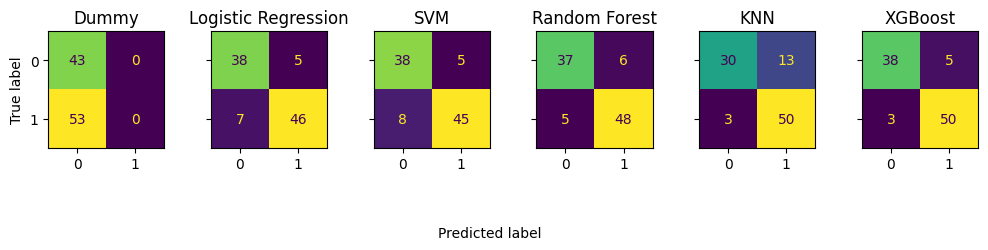

In [ ]:
#@title Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['Dummy', 'Logistic Regression', 'SVM', 'Random Forest', 'KNN', 'XGBoost']

f, axes = plt.subplots(1, 6, figsize=(12, 5), sharey='row')

for i in range(6):
    cf_matrix = confusion_matrix(y_test, y_pred[i])
    disp = ConfusionMatrixDisplay(cf_matrix,)
    disp.plot(ax=axes[i],)
    disp.ax_.set_title(labels[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.2, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()

By comparing each result, we can obtain the genes that are repeated in every RBA implementation. The validity of these genes as biomarkers should be confirmed by a gene enrichment analysis.

In [ ]:
importances = [fs_surf, fs_surf2, fs_multi_surf, fs_multi_surf2, fs_turf]
vec = np.array([])
for fs in importances:
  fs_positive = fs[fs['Feature importances'] > 0]
  vec = np.append(vec, fs_positive['Features'])

values, counts = np.unique(vec, return_counts = True)
final_result = pd.DataFrame({'Unique genes': values, 'Repetitions': counts})
final_result = final_result.sort_values(by = ['Repetitions'], ascending = False)
final_result = final_result.reset_index(drop = True)
final_result = final_result[final_result['Repetitions'] == np.max(final_result['Repetitions'])]
final_result

,Unique genes,Repetitions
0,lincRNA:chrX:133675909-133683184_R,5
1,XR_110003,5
2,NM_002996,5
3,NM_000393,5
4,NM_000559,5
...,...,...
115,NM_004277,5
116,AK055745,5
117,ENST00000276974,5
118,NM_152380,5
